In [1]:
import os 
import numpy as np
import torch
from utils1 import * 
import h5py
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

print(device)

cuda:0


In [11]:
train_file_path = '/home/rishabh.mondal/final_train.hdf5'
test_file_path = '/home/rishabh.mondal/delhi_NCR.h5'

In [12]:
images, labels = load_hdf5_data(test_file_path) 
show_random_images_with_labels(test_file_path, num_images=10)

OSError: Unable to open file (truncated file: eof = 148111360, sblock->base_addr = 0, stored_eof = 543055440)

In [4]:
x_train, y_train = load_hdf5_data(train_file_path)
x_test, y_test = load_hdf5_data(test_file_path)

Images shape:  (2186, 256, 256, 3)
Labels shape:  (2186,)
Images shape:  (618, 256, 256, 3)
Labels shape:  (618,)


In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
class_0_train_count=np.sum(y_train==0)
class_1_train_count=np.sum(y_train==1)
class_0_val_count=np.sum(y_val==0)
class_1_val_count=np.sum(y_val==1)
class_0_test_count=np.sum(y_test==0)
class_1_test_count=np.sum(y_test==1)
print("Total train count: ", len(y_train))
print("Train class train 0 count: ", class_0_train_count)
print("Train class train 1 count: ", class_1_train_count)
print("Val class val 0 count: ", class_0_val_count)
print("Val class val 1 count: ", class_1_val_count)
print("Test class test 0 count: ", class_0_test_count)
print("Test class test 1 count: ", class_1_test_count)


Total train count:  1748
Train class train 0 count:  1533
Train class train 1 count:  215
Val class val 0 count:  384
Val class val 1 count:  54
Test class test 0 count:  545
Test class test 1 count:  73


In [6]:


resized_x_train = np.zeros((x_train.shape[0], 224, 224, 3), dtype=np.uint8)
print(resized_x_train.shape)
resized_x_test = np.zeros((x_test.shape[0], 224, 224, 3), dtype=np.uint8)
resized_x_val = np.zeros((x_val.shape[0], 224, 224, 3), dtype=np.uint8)
for i in range(x_train.shape[0]):
    img = Image.fromarray(x_train[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_train[i] = np.array(img)

for i in range(x_test.shape[0]):
    img = Image.fromarray(x_test[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_test[i] = np.array(img)

for i in range(x_val.shape[0]):
    img = Image.fromarray(x_val[i])
    img = img.resize((224, 224), Image.ANTIALIAS)
    resized_x_val[i] = np.array(img)    

(1748, 224, 224, 3)


/tmp/ipykernel_3096051/2002680331.py:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
/tmp/ipykernel_3096051/2002680331.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
/tmp/ipykernel_3096051/2002680331.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


In [7]:
print(resized_x_train.shape)

(1748, 224, 224, 3)


In [8]:
from torch.utils.data import DataLoader, TensorDataset


In [9]:
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2), torch.tensor(y_test, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary




In [11]:
def resnet50(larning_rate=0.0002,fine_tune=True,seed=4):
    torch.manual_seed(seed)    
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad = False

    num_fitrs = resnet.fc.in_features
    resnet.fc = nn.Sequential(
        nn.Linear(num_fitrs, 2048),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(2048, 1),
        nn.Sigmoid()
    )    
    criterion=nn.BCELoss()
    optimizer = torch.optim.Adam(resnet.parameters(), lr=larning_rate)
    return resnet, criterion, optimizer

# def resnet101(larning_rate=0.0002,fine_tune=True,seed=42):
#     torch.manual_seed(seed)    
#     resnet = models.resnet101(pretrained=True)
#     for param in resnet.parameters():
#         param.requires_grad = False

#     num_fitrs = resnet.fc.in_features
#     resnet.fc = nn.Sequential(
#         nn.Linear(num_fitrs, 2048),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(2048, 1),
#         nn.Sigmoid()
#     )    
#     criterion=nn.BCELoss()
#     optimizer = torch.optim.Adam(resnet.parameters(), lr=larning_rate)
#     return resnet, criterion, optimizer

# def dense_net(larning_rate=0.0002,fine_tune=True,seed=42):
#     torch.manual_seed(seed)    
#     densenet = models.densenet121(pretrained=True)
#     for param in densenet.parameters():
#         param.requires_grad = False

#     num_fitrs = densenet.classifier.in_features
#     densenet.classifier = nn.Sequential(
#         nn.Linear(num_fitrs, 1024),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(1024, 1),
#         nn.Sigmoid()
#     )    
#     criterion=nn.BCELoss()
#     optimizer = torch.optim.Adam(densenet.parameters(), lr=larning_rate)
#     return densenet, criterion, optimizer

# def vgg16(larning_rate=0.0002,fine_tune=True,seed=42):
#     torch.manual_seed(seed)    
#     vgg = models.vgg16(pretrained=True)
#     for param in vgg.parameters():
#         param.requires_grad = False

#     num_fitrs = vgg.classifier[6].in_features
#     vgg.classifier = nn.Sequential(
#         nn.Linear(num_fitrs, 1024),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(1024, 1),
#         nn.Sigmoid()
#     )    
#     criterion=nn.BCELoss()
#     optimizer = torch.optim.Adam(vgg.parameters(), lr=larning_rate)
#     return vgg, criterion, optimizer

In [12]:
#summery of model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seeds = [42, 44,48,56,88,10,26,16,90,100]
for seed in seeds:
    model, criterion, optimizer = resnet50(seed=seed)
    model = model.to(device)
    summary(model, (3, 224, 224))
    del model, criterion, optimizer


# model, criterion, optimizer = resnet50()
# model = model.to(device)

# model1, criterion1, optimizer1 = resnet101()
# model1 = model1.to(device)

# model2, criterion2, optimizer2 = dense_net()
# model2.to(device)
# model3, criterion3, optimizer3 = vgg16()
# model3.to(device)


/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
train_losses_per_seed = []
train_accuracies_per_seed = []


val_losses_per_seed = []
val_accuracies_per_seed = []


test_losses_per_seed = []
test_accuracies_per_seed = []

In [14]:

for seed in seeds:
    model, criterion, optimizer = resnet50(seed=seed)
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    num_epochs = 100

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_samples = 0
        total_correct = 0
        for images,labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            output = output.squeeze(dim=1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += (output.round() == labels).sum().item()

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = (total_correct / total_samples)*100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_total_samples = 0
        val_total_correct = 0
        with torch.no_grad():
            for images,labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                outputs = outputs.squeeze(dim=1)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()
                val_total_samples += labels.size(0)
                val_total_correct += (outputs.round() == labels).sum().item()
                
            val_loss = val_loss / len(val_loader)
            val_acc = (val_total_correct / val_total_samples)*100
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

    val_accuracies_per_seed.append(val_accuracies)
    val_losses_per_seed.append(val_losses)    
    train_losses_per_seed.append(train_losses)
    train_accuracies_per_seed.append(train_accuracies)   

    print(f'Final validation loss and accuracy for seed {seed}: {val_losses[-1]:.4f}', f'{val_accuracies[-1]:.4f}')
    print(f'Final training loss and and accuracy for  seed {seed}: {train_losses[-1]:.4f}', f'{train_accuracies[-1]:.4f}')


    true_labels = []
    predicted_labels = []
    model.eval()  
    test_loss = 0.0
    test_total_samples = 0
    test_total_correct = 0
    with torch.no_grad():  
        for images,labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            output = output.squeeze(dim=1)

            loss = criterion(output, labels)
            test_loss += loss.item()

            predicted = (output.round() == 1.0)  
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())        

            test_total_samples += labels.size(0)
            test_total_correct += (output.round() == labels).sum().item()

        test_accuracy = (test_total_correct / test_total_samples) * 100
    test_accuracies_per_seed.append(test_accuracy)
    
    print(f'Final test accuracy for seed {seed}: {test_accuracy:.4f}')

Final validation loss and accuracy for seed 42: 0.2509 94.0639
Final training loss and and accuracy for  seed 42: 0.0449 99.0275
Final test accuracy for seed 42: 92.8803
Final validation loss and accuracy for seed 44: 0.2682 89.7260
Final training loss and and accuracy for  seed 44: 0.0468 98.9130
Final test accuracy for seed 44: 89.8058
Final validation loss and accuracy for seed 48: 0.2563 94.7489
Final training loss and and accuracy for  seed 48: 0.0403 98.5698
Final test accuracy for seed 48: 92.7184
Final validation loss and accuracy for seed 56: 0.2515 94.0639
Final training loss and and accuracy for  seed 56: 0.0278 99.4279
Final test accuracy for seed 56: 93.3657


In [ ]:
# print(train_losses)
# print(train_losses_per_seed)

[0.3873524016567639, 0.28557625891906874, 0.22757086317454064, 0.20136355103126594, 0.18113649051104272, 0.1796974278986454, 0.19741637472595489, 0.15905597739453828, 0.15370104355471476, 0.15101810837430613]
[[0.3745257875749043, 0.2735365575977734, 0.2195247621940715, 0.2003467535333974, 0.18184600145156896, 0.17305443861654826, 0.16312590853444167, 0.14712542667984962, 0.16115495136805943, 0.13673562024320876], [0.3873524016567639, 0.28557625891906874, 0.22757086317454064, 0.20136355103126594, 0.18113649051104272, 0.1796974278986454, 0.19741637472595489, 0.15905597739453828, 0.15370104355471476, 0.15101810837430613]]


In [ ]:
print(test_accuracies_per_seed)

NameError: name 'test_accuracies_per_seed' is not defined

In [ ]:
train_losses_per_seed = np.array(train_losses_per_seed)
train_accuracies_per_seed = np.array(train_accuracies_per_seed)


mean_train_losses = np.mean(train_losses_per_seed, axis=0)
var_train_losses = np.var(train_losses_per_seed, axis=0)
mean_train_accuracies = np.mean(train_accuracies_per_seed, axis=0)
var_train_accuracies = np.var(train_accuracies_per_seed, axis=0)

In [ ]:
val_losses_per_seed = np.array(val_losses_per_seed)
val_accuracies_per_seed = np.array(val_accuracies_per_seed)

mean_val_losses = np.mean(val_losses_per_seed, axis=0)
var_val_losses = np.var(val_losses_per_seed, axis=0)
mean_val_accuracies = np.mean(val_accuracies_per_seed, axis=0)
var_val_accuracies = np.var(val_accuracies_per_seed, axis=0)

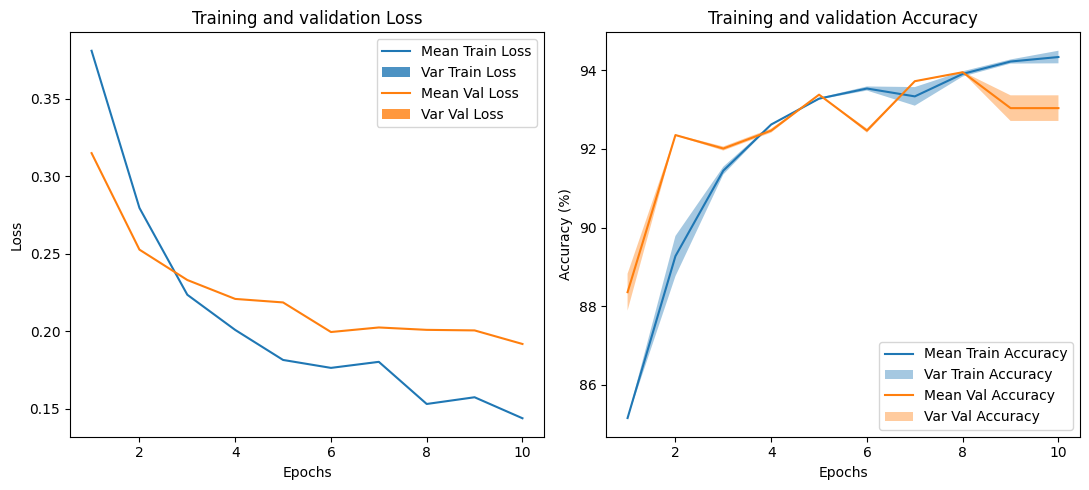

In [ ]:
epochs = range(1, num_epochs + 1)
# Plot mean and variance for training loss
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_train_losses,label='Mean Train Loss')
plt.fill_between(epochs, mean_train_losses - var_train_losses, mean_train_losses + var_train_losses, alpha=.8, label='Var Train Loss')
plt.plot(epochs, mean_val_losses, label='Mean Val Loss')
plt.fill_between(epochs, mean_val_losses - var_val_losses, mean_val_losses + var_val_losses, alpha=.8, label='Var Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.legend()

# Plot mean and variance for training accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_train_accuracies, label='Mean Train Accuracy')
plt.fill_between(epochs, mean_train_accuracies - var_train_accuracies, mean_train_accuracies + var_train_accuracies, alpha=0.4, label='Var Train Accuracy')
plt.plot(epochs, mean_val_accuracies, label='Mean Val Accuracy')
plt.fill_between(epochs, mean_val_accuracies - var_val_accuracies, mean_val_accuracies + var_val_accuracies, alpha=0.4, label='Var Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and validation Accuracy')
plt.legend()
plt.tight_layout();
plt.savefig('resnet50 - Train and val.png')

Precision: 0.7377, Recall: 0.6164, F1-score: 0.6716


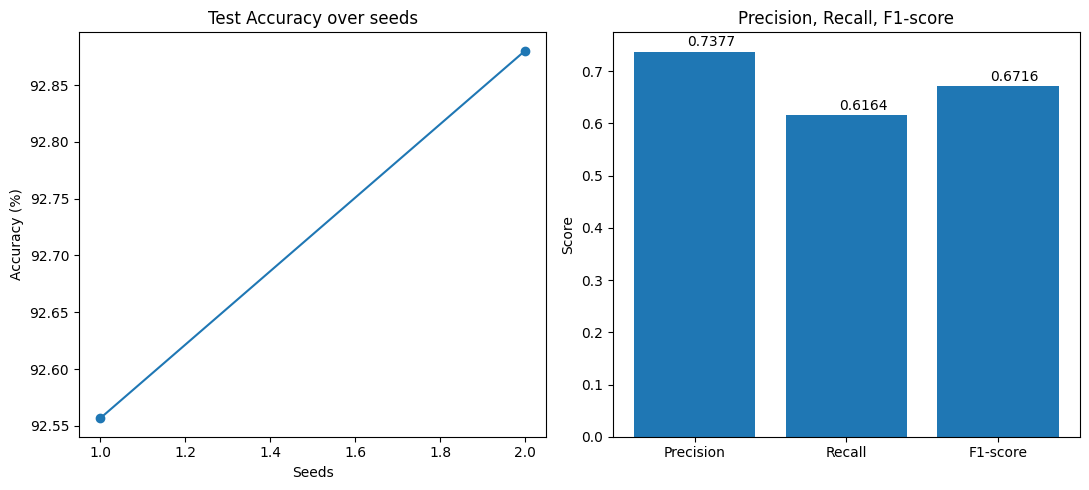

In [ ]:
#plot test accuracy over seeds
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(seeds, test_accuracies_per_seed, 'o-')
plt.xlabel('Seeds')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over seeds')   
plt.savefig('resnet50 - Test.png');

plt.subplot(1, 2, 2)
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
print('Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}'.format(precision, recall, fscore))
#create the bar chart to show the precision, recall, f1-score
plt.bar(['Precision', 'Recall', 'F1-score'], [precision, recall, fscore])
plt.title('Precision, Recall, F1-score')
plt.ylabel('Score')

#exect score at the top of the bar chart 
for i, v in enumerate([precision, recall, fscore]):
    plt.text(i - 0.05, v + 0.01, str(round(v, 4)))

plt.tight_layout();    
plt.savefig('resnet50 - Precision, Recall, F1-score.png');




In [ ]:
# plot classifcation report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=['class 0', 'class 1']))


              precision    recall  f1-score   support

     class 0       0.95      0.97      0.96       545
     class 1       0.74      0.62      0.67        73

    accuracy                           0.93       618
   macro avg       0.84      0.79      0.82       618
weighted avg       0.92      0.93      0.93       618



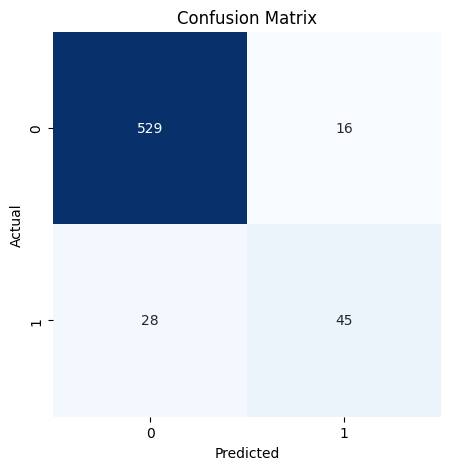

In [ ]:
#plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');


In [ ]:
# for key, var in locals().items():
#     if isinstance(var, torch.Tensor):
#        locals()[key] = var.cuda()
#     if isinstance(var, torch.nn.Module):
#        locals()[key] = var.cuda() 